# 分位数回归

分位数回归（Quantile regression）是在给定$X$条件下，估计$y$的中位数或其他分位数，而普通最小二乘法（OLS）估计的是条件均值。

作为线性模型，QuantileRegressor对于第 $q$ 个分位数 $q \in (0, 1)$，给出线性预测 $\hat{y}(w, X) = Xw$ 。然后，通过以下最小化问题来找到权重或系数 $w$：

$
\min_{w} {\frac{1}{n_{\text{samples}}} \sum_i PB_q(y_i - X_i w) + \alpha ||w||_1}.
$

其中包含损失函数$pinball loss$（也称为线性损失）,

$ PB_q(t) = q \max(t, 0) + (1 - q) $

$
\max(-t, 0) = 
\begin{cases} 
q t, & t > 0, \\ 
0, & t = 0, \\ 
(q-1) t, & t < 0 
\end{cases}
$

以及由参数alpha控制的L1惩罚项，类似于Lasso。

由于pinball损失函数在残差方面是线性的，因此分位数回归比基于平方误差的均值估计方法更具鲁棒性。HuberRegressor则介于两者之间。

如果你关心的是预测一个区间而不是点预测，分位数回归可能会很有用。有时，基于预测误差服从零均值和恒定方差的正态分布的假设计算预测区间。而分位数回归可以为具有非恒定（但可预测）方差或非正态分布的误差提供合理的预测区间。

下面是个分位数回归示例：

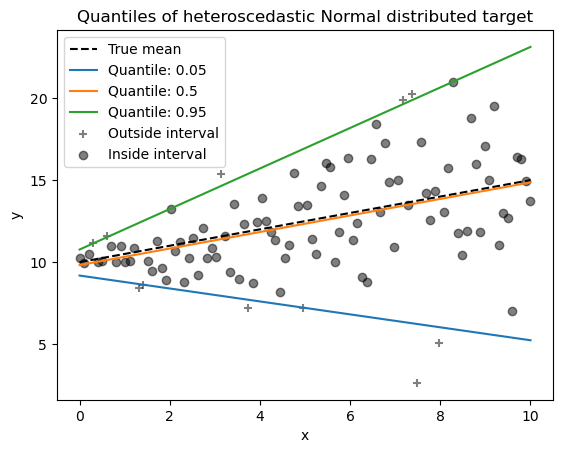

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.fixes import parse_version, sp_version
from sklearn.linear_model import QuantileRegressor

# 创建一个随机数生成器
rng = np.random.RandomState(42)

# 生成自变量X
x = np.linspace(start=0, stop=10, num=100)
X = x[:, np.newaxis]

# 生成真实的y均值
y_true_mean = 10 + 0.5 * x

# 使用正态分布生成带有异方差性的y_normal
y_normal = y_true_mean + rng.normal(loc=0, scale=0.5 + 0.5 * x, size=x.shape[0])

# 定义pareto分布的参数a，并使用pareto分布生成带有异方差性的y_pareto
a = 5
y_pareto = y_true_mean + 10 * (rng.pareto(a, size=x.shape[0]) - 1 / (a - 1))

# 定义需要预测的分位数
quantiles = [0.05, 0.5, 0.95]

# 存储预测结果的字典
predictions = {}

# 存储超出区间的预测结果的布尔数组
out_bounds_predictions = np.zeros_like(y_true_mean, dtype=np.bool_)

# 针对每个分位数进行预测
for quantile in quantiles:
    # 创建QuantileRegressor对象，并进行拟合和预测
    qr = QuantileRegressor(quantile=quantile, alpha=0, solver='highs')
    y_pred = qr.fit(X, y_normal).predict(X)
    predictions[quantile] = y_pred

    # 根据分位数将超出区间的预测结果标记为True
    if quantile == min(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred >= y_normal
        )
    elif quantile == max(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred <= y_normal
        )

# 绘制真实均值的虚线
plt.plot(X, y_true_mean, color="black", linestyle="dashed", label="True mean")

# 针对每个分位数绘制预测曲线
for quantile, y_pred in predictions.items():
    plt.plot(X, y_pred, label=f"Quantile: {quantile}")

# 绘制超出区间的数据点和内部区间的数据点
plt.scatter(
    x[out_bounds_predictions],
    y_normal[out_bounds_predictions],
    color="black",
    marker="+",
    alpha=0.5,
    label="Outside interval"
)
plt.scatter(
    x[~out_bounds_predictions],
    y_normal[~out_bounds_predictions],
    color="black",
    alpha=0.5,
    label="Inside interval"
)

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
_ = plt.title("Quantiles of heteroscedastic Normal distributed target")